MobileNet V1 and V2: A PyTorch Tutorial




In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [ ]:
# Enter your information here
first_and_last_name = 'mohammad hasan borjal bayatiany'
std_number = '401105691'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [ ]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [ ]:
import numpy as np

def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float or numpy.ndarray): Scale parameter, shape can be (features,) or scalar.
        beta (float or numpy.ndarray): Shift parameter, shape can be (features,) or scalar.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)

    x_normalized = (x - mean) / np.sqrt(variance + epsilon)

    output = gamma * x_normalized + beta

    return output

In [ ]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

half_part = np.arange(len(train_set) // 2)
train_subset = Subset(train_set, half_part)
train_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=64, shuffle=False, num_workers=2)

val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

val_loader = DataLoader(
    val_set, batch_size=64, shuffle=False, num_workers=2)

# TEST DATA (Using half of the original test set)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

test_loader = DataLoader(
    test_set, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
*answer*
The functions used in the data transformations help prepare the images for training and testing. RandomResizedCrop(224, scale=(0.5, 1.0)) randomly crops a region from the image and resizes it to 224x224 pixels, with the crop size varying between 50% and 100% of the original image size. RandomHorizontalFlip() randomly flips the image horizontally with a 50% probability, aiding in data augmentation. ToTensor() converts the image to a PyTorch tensor with pixel values scaled to [0, 1], eliminating the need for additional normalization. Normalize(mean, std) normalizes the image by adjusting the mean and standard deviation for each channel. While the training transform incorporates data augmentation (like cropping and flipping) to improve model generalization, the test transform typically uses only resizing and normalization to ensure consistent input during evaluation.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

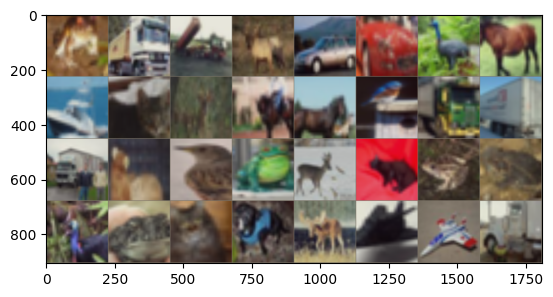

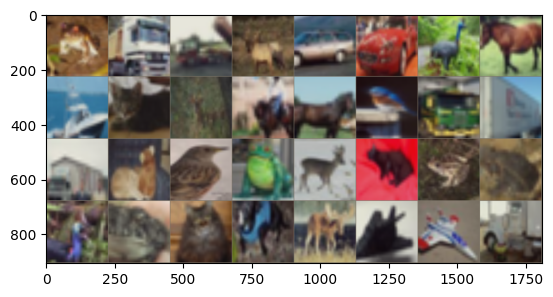

In [ ]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()
dataiter = iter(train_loader)

images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [ ]:
MODEL_SAVE_PATH = './model.pt'



def fit_epoch(model, data_loader, criterion, optimizer, train_mode=False):

    if train_mode:
      model.train()
    else:
      model.eval()

    epoch_losses = []
    running_loss = 0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if train_mode:
              loss.backward()
              optimizer.step()
            preds = torch.argmax(outputs, 1)

        epoch_losses += [loss.item()]
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    epoch_loss = running_loss / processed_data
    epoch_acc = running_corrects.cpu().numpy() / processed_data

    if train_mode:
      print("train_loss: {:0.4f} | train_acc: {:0.4f}".format(epoch_loss, epoch_acc))
    else:
      print("  val_loss: {:0.4f} |   val_acc: {:0.4f}".format(epoch_loss, epoch_acc))

    return epoch_losses


def train(train_loader, val_loader, model, epochs, lr=1e-3):

    all_train_losses, all_val_losses = [], []
    best_val_loss = float('inf')
    MODEL_SAVE_PATH = './model.pt'

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        print('EPOCH #', epoch+1)
        train_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_losses   = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        all_train_losses += train_losses

        val_loss = np.array(val_losses).mean()
        all_val_losses += [val_loss]

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return all_train_losses, all_val_losses



def get_acc(model, val_loader):

    model.eval()
    running_corrects = 0
    processed_data = 0

    with torch.set_grad_enabled(False):
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)

    epoch_acc = running_corrects.cpu().numpy() / processed_data
    return epoch_acc



def plot_losses(train_losses, val_losses, c_window=10):
    epochs = len(val_losses)
    train_losses_c = np.convolve(np.array(train_losses[:]),
                                np.ones(c_window)/c_window, mode='valid')

    plt.plot(train_losses_c, label='train_losses')
    plt.plot([i*len(train_losses)/epochs for i in range(1, epochs+1)], np.array(val_losses),
            label='val_losess', marker='o', markersize=8)
    plt.legend()
    plt.grid()
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [ ]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**
Depthwise separable convolution speeds up models by splitting standard convolution into two stages—depthwise convolution and pointwise convolution—significantly reducing parameters and computations for enhanced efficiency, especially on resource-limited devices.

Now please create your model.

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:
epochs = 10
lr = 1e-3

model = MobileNet(n_class=10).to(device)

start_time = time.time()
train_losses, val_losses = train(train_loader, test_loader, model, epochs, lr)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.6532 | train_acc: 0.3880


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.5440 |   val_acc: 0.4608
EPOCH # 2


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.2925 | train_acc: 0.5359


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.1115 |   val_acc: 0.6023
EPOCH # 3


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.0874 | train_acc: 0.6125


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.9930 |   val_acc: 0.6567
EPOCH # 4


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.9448 | train_acc: 0.6660


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.8037 |   val_acc: 0.7195
EPOCH # 5


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.8329 | train_acc: 0.7060


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7809 |   val_acc: 0.7321
EPOCH # 6


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.7587 | train_acc: 0.7363


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6950 |   val_acc: 0.7610
EPOCH # 7


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.6777 | train_acc: 0.7682


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6342 |   val_acc: 0.7813
EPOCH # 8


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.6309 | train_acc: 0.7796


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6080 |   val_acc: 0.7935
EPOCH # 9


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.5839 | train_acc: 0.7980


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6080 |   val_acc: 0.7929
EPOCH # 10


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.5439 | train_acc: 0.8122


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6382 |   val_acc: 0.7897
Training time: 1070.79 seconds


Get some metrics and plot your losses.

  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7897
Process validation time: 19.3018 s


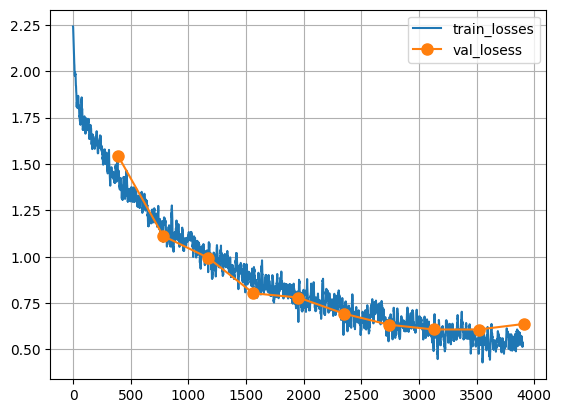

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**
The number of FLOPs (floating-point operations) for a standard convolution layer is calculated as 2 × C_in × C_out × K² × H × W, where C_in is the number of input channels, C_out is the number of output channels, K is the kernel size, and H and W are the input height and width. In depthwise separable convolution, the computation is split into two parts: depthwise convolution, which applies a single filter per input channel with FLOPs calculated as 2 × C_in × K² × H × W, and pointwise convolution, which combines the outputs of the depthwise convolution using a 1 × 1 convolution, with FLOPs given by 2 × C_in × C_out × H × W. The total FLOPs for depthwise separable convolution are the sum of these two components, which results in significantly fewer FLOPs than standard convolution, typically making it 8 to 9 times faster.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
epochs = 2
lr = 1e-3

cnn_normal = NormalCNN(10).to(device)

start_time = time.time()
train_losses, val_losses = train(train_loader, test_loader, cnn_normal, epochs, lr)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.9468 | train_acc: 0.2529


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.7485 |   val_acc: 0.3276
EPOCH # 2


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.7196 | train_acc: 0.3523


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.6780 |   val_acc: 0.3897
Training time: 336.33 seconds


  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.7897
Process validation time: 17.9492 s


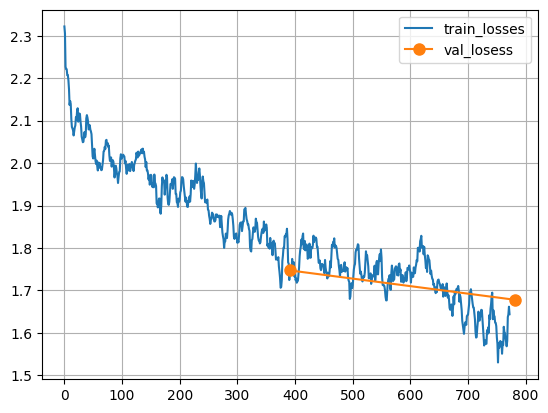

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**
Normal CNN:
The learning speed is slower due to a higher number of parameters and computational complexity. Similarly, the validation speed is also slower because of the increased computational load.

MobileNet:
The learning speed is faster, thanks to fewer parameters and the use of efficient depthwise separable convolutions. Validation speed is significantly improved, benefiting from reduced complexity and optimized operations.

In [ ]:
cnn_normall = NormalCNN(10)
print('Total number of normal CNN parameters:', sum(p.numel() for p in cnn_normall.parameters() if p.requires_grad))
mobile_nett = MobileNet(10)
print('Total number of MobileNet parameters:', sum(p.numel() for p in mobile_nett.parameters() if p.requires_grad))

Total number of normal CNN parameters: 28279338
Total number of MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [ ]:
model = MobileNet(n_class=100).to(device)

pretrained_dict = torch.load('model.pt', map_location=device, weights_only=True)
model_dict = model.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [ ]:
layer_counter = 0
for layer in model.model.children():
    layer_counter += 1
    if layer_counter <= 7:  # Freeze up to layer 7
        for param in layer.parameters():
            param.requires_grad = False
    else:  # Unfreeze the rest
        for param in layer.parameters():
            param.requires_grad = True

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [ ]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

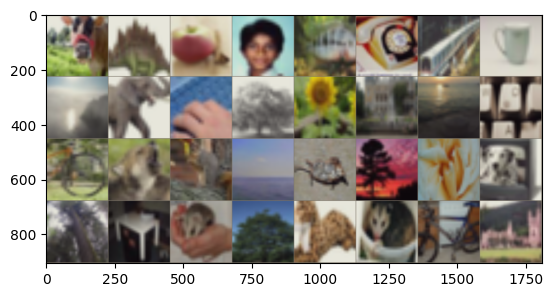

tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17, 47, 65, 21, 22,
        81, 11, 24, 84, 78, 45, 49, 97, 56, 76, 11, 90, 89, 78, 73, 14, 87,  9,
        71,  6, 47, 20, 98, 47, 36, 55, 72, 43, 51, 35, 83, 33, 27, 53, 92, 50,
        15, 89, 36, 18, 89, 46, 33, 42, 39, 64, 75, 38, 23, 42, 66, 77, 49, 18,
        46, 15, 35, 69, 95, 83, 75, 99, 73, 93, 55, 39,  4, 97, 61, 93, 51, 69,
        56, 84, 59, 64, 94,  4, 11, 33, 68, 38, 20, 33, 34, 32, 46, 53, 88, 67,
        70, 64])


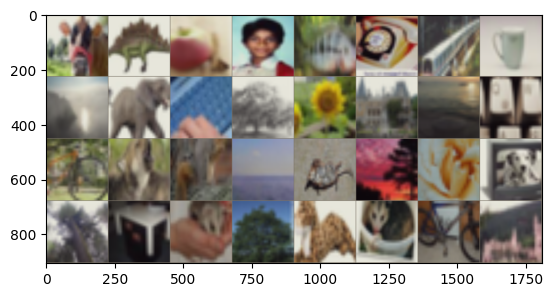

In [ ]:
# show some training images with shuffle=False and labels
n_shuf = torch.utils.data.DataLoader(train_set100, batch_size=128, shuffle=False)
data_iter = iter(n_shuf)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images[:32], nrow=8))
print(labels)

# show them again to check the augmentation
data_iter = iter(n_shuf)
images2, labels2 = next(data_iter)
imshow(torchvision.utils.make_grid(images2[:32], nrow=8))

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer**
Yes, both CIFAR-10 and CIFAR-100 use the same set of 60,000 images, but they differ in the number and specificity of their labels. CIFAR-10 has 10 classes with broader categories like "cat" and "dog," while CIFAR-100 has 100 classes with more specific labels, such as "Persian cat" and "Boeing 737." In conclusion, while the two datasets share the same images, CIFAR-100 provides more detailed and fine-grained labels, making it a more challenging dataset compared to CIFAR-10.

Now train your model using your functions.

In [ ]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

  0%|          | 0/7 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 4.3954 | train_acc: 0.0431


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 4.2635 |   val_acc: 0.0568
EPOCH # 2


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 4.0830 | train_acc: 0.0790


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 4.0368 |   val_acc: 0.0853
EPOCH # 3


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.9103 | train_acc: 0.1122


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.8981 |   val_acc: 0.1077
EPOCH # 4


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.7842 | train_acc: 0.1335


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.7953 |   val_acc: 0.1238
EPOCH # 5


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.6779 | train_acc: 0.1571


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.6740 |   val_acc: 0.1569
EPOCH # 6


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.5807 | train_acc: 0.1734


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.6192 |   val_acc: 0.1609
EPOCH # 7


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.4926 | train_acc: 0.1938


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.5893 |   val_acc: 0.1661


Get some metrics and plot your losses.

  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.1661
Process validation time: 17.7375 s


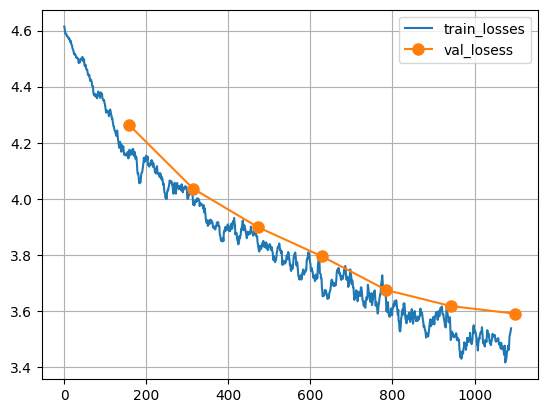

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer**
  Prevention of Numeric Overflow: By restricting the activation values to the range [0, 6], ReLU6 helps prevent numerical instability, particularly in quantized neural networks.
  Improved Performance in Quantized Networks: ReLU6 performs well with lower-precision representations, such as 8-bit integers, which are commonly used in mobile and embedded systems.    Bounded Activation Range: By keeping activations within a fixed range, ReLU6 can improve performance in scenarios where large activations might negatively impact the subsequent layers.

In [ ]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()

        self.use_res_connect = (stride == 1) and (inp == oup)
        hidden_dim = int(inp * expand_ratio)

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, input_dim=224, width_factor=1.0):

        config = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]
        super(MobileNetV2, self).__init__()
        self.input_dim = input_dim
        initial_channels = int(32 * width_factor)
        self.layers = [conv_bn(3, initial_channels, 2)]
        for expand_ratio, channels, repeats, stride in config:
            output_channels = int(channels * width_factor)
            for i in range(repeats):
                if i == 0:
                    self.layers.append(InvertedResidual(initial_channels, output_channels, stride, expand_ratio=expand_ratio))
                else:
                    self.layers.append(InvertedResidual(initial_channels, output_channels, 1, expand_ratio=expand_ratio))
                initial_channels = output_channels
        self.layers.append(conv_1x1_bn(initial_channels, int(1280 * width_factor)))
        self.layers = nn.Sequential(*self.layers)
        self.head = nn.Linear(int(1280 * width_factor), num_classes)

    def forward(self, inputs):
        x = self.layers(inputs)
        x = x.mean(3).mean(2)
        x = self.head(x)
        return x

How did you create linear bottlenecks? How do they help?


**answer**
In the MobileNetV2 architecture, linear bottlenecks are implemented using InvertedResidual blocks. The process involves expanding channels, applying depthwise convolution, and then reducing the channels. This approach helps reduce the number of parameters and achieve dimensionality reduction, keeping the model lightweight while minimizing information loss during the reduction process. Ultimately, this design enhances the balance between efficiency and performance, making it well-suited for mobile applications.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [ ]:
model = MobileNetV2(num_classes=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.6559 | train_acc: 0.3904


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.5486 |   val_acc: 0.4555
EPOCH # 2


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.2892 | train_acc: 0.5365


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.2477 |   val_acc: 0.5655
EPOCH # 3


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.1133 | train_acc: 0.6023


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.0372 |   val_acc: 0.6339
EPOCH # 4


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.9721 | train_acc: 0.6583


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.9922 |   val_acc: 0.6691
EPOCH # 5


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.8878 | train_acc: 0.6853


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.8102 |   val_acc: 0.7158
EPOCH # 6


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.8191 | train_acc: 0.7094


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7823 |   val_acc: 0.7299
EPOCH # 7


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.7522 | train_acc: 0.7371


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7401 |   val_acc: 0.7444
EPOCH # 8


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.7179 | train_acc: 0.7520


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7048 |   val_acc: 0.7597
EPOCH # 9


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.6731 | train_acc: 0.7637


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6743 |   val_acc: 0.7745
EPOCH # 10


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.6392 | train_acc: 0.7757


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6295 |   val_acc: 0.7923


Get some metrics and plot your losses.

  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7923
Process validation time: 18.4583 s


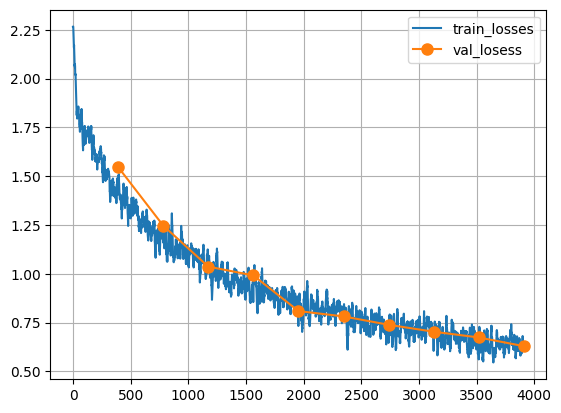

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [ ]:
for wf in [i / 10 for i in range(1, 11)]:
    model = MobileNetV2(num_classes=10, width_factor=wf)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"with {wf} width multipier we got {num_params} parameters")

with 0.1 width multipier we got 31255 parameters
with 0.2 width multipier we got 105224 parameters
with 0.3 width multipier we got 221676 parameters
with 0.4 width multipier we got 380438 parameters
with 0.5 width multipier we got 587178 parameters
with 0.6 width multipier we got 826943 parameters
with 0.7 width multipier we got 1113168 parameters
with 0.8 width multipier we got 1441788 parameters
with 0.9 width multipier we got 1812806 parameters
with 1.0 width multipier we got 2236682 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [ ]:
MNv2_path = './MNv2WMmodel.pt'

model_MNv2 = MobileNetV2(n_class=10, width_multiplier=0.5)
model_MNv2.load_state_dict(torch.load(MNv2_path, weights_only=True))
model_MNv2.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(8, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3

In [ ]:
start = time.time()
val_acc = get_acc(model_MNv2, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


<ipython-input-89-c60799410c7d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_MNv2.load_state_dict(torch.load(MNv2_path, map_location=device))


  0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.7432
Process validation time: 20.6450 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**
For a layer with input channels (m) and output channels (n), using a width multiplier (alpha), the number of channels becomes α×mα×m for input channels and α×nα×n for output channels. As a result, the total number of parameters is α2×(m×n)α2×(m×n). For example, when α=1α=1, the number of parameters remains unchanged, while α=0.25α=0.25 reduces the parameters by a factor of 16 (14)2(41​)2. The trade-off is that a higher αα leads to a larger model with more parameters and potentially better performance but higher computational cost, while a lower αα results in a smaller model with fewer parameters, lower computational cost, but possibly reduced accuracy.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**
The resolution multiplier adjusts the input image size to the model, such as reducing the resolution from 224x224 to 112x112. Using a lower resolution multiplier makes the model faster, as smaller input images require fewer computations in each convolutional layer, resulting in reduced computational load and quicker forward and backward passes during training and inference. While the resolution multiplier does not directly affect the number of parameters, as these depend on kernel sizes, the number of channels, and layers, it indirectly improves efficiency. With smaller input sizes, the effective workload per parameter decreases, leading to faster processing without changing the number of parameters.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**
Models with too many parameters are at risk of overfitting, as they may learn noise rather than meaningful patterns, leading to poor performance on unseen data. From a resource efficiency perspective, more parameters increase memory usage, as larger models require more memory, which can exceed the capabilities of even powerful GPUs. Additionally, training time grows with more parameters, leading to higher costs and delays in model deployment. Larger models also tend to slow down inference speed, which can be critical in real-time applications like autonomous driving or live video analysis. Moreover, models with more parameters consume more energy, raising concerns about the environmental impact of large-scale AI models, making efficiency a key consideration.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [ ]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


  0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.0973
Process validation time: 18.5882 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temp = temperature
        self.alpha = alpha
        self.kl_divergence = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        teacher_prob = F.softmax(teacher_logits / self.temp, dim=1)
        student_log_prob = F.log_softmax(student_logits / self.temp, dim=1)
        distillation_loss = self.kl_divergence(student_log_prob, teacher_prob) * (self.temp ** 2)
        classification_loss = F.cross_entropy(student_logits, labels)
        total_loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
        return total_loss

def train_student(teacher: nn.Module, student: nn.Module, train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, device: torch.device, epochs: int = 10, lr: float = 0.01) -> None:
    teacher.to(device).eval()
    student.to(device)

    loss_fn = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        epoch_loss = 0.0
        for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, lbls = imgs.to(device), lbls.to(device)
            with torch.no_grad():
                teacher_out = teacher(imgs)
            student_out = student(imgs)
            loss = loss_fn(student_out, teacher_out, lbls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")


Train it for one epoch to just check if it works.

In [ ]:
student = MobileNetV2(num_classes=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 1/1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/1, Loss: 0.9964


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer**
A high alpha value (like 0.9) places a strong emphasis on matching the ground truth labels, which can improve task-specific performance but increases the risk of overfitting. This is beneficial in situations where precise alignment with the target task is critical. On the other hand, a low alpha value (like 0.1) focuses more on learning from the teacher’s knowledge, helping the model generalize better across diverse datasets, though it might underfit and not align as well with specific tasks. The trade-off is that a high alpha improves precision for specific tasks but risks overfitting, while a low alpha improves generalization but may not perfectly match the target tasks. A balanced alpha (like 0.5) can offer a good compromise, leveraging both the ground truth and the teacher’s expertise, leading to a balance between task performance and generalization.